# Multivariate time series prediction with LSTM



In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
import pickle

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

matplotlib.rcParams['figure.figsize'] = (17, 5)
matplotlib.rcParams['axes.grid'] = False
sns.set_style("whitegrid")


Tensorflow Version: 2.9.1
Pandas Version: 1.4.3
Numpy Version: 1.22.4
System Version: 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]


## Load Data


In [2]:

df = pd.read_csv('data.csv', index_col=0)
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())
print(f'Length of data : {len(df)}')
dataset = df.values

DataFrame Shape: 26281 rows, 3 columns


,FL,SL,RL
2000-01-01 10:00:00,5336.320000,-0.04,-0.13
2000-01-01 11:00:00,5323.263760,0.25,-0.08
2000-01-01 12:00:00,5310.548261,0.35,0.09
2000-01-01 13:00:00,5298.163925,0.43,0.35
2000-01-01 14:00:00,5286.110754,0.35,0.52


Length of data : 26281


In [3]:
# Data Loader Parameters
BATCH_SIZE = 128
BUFFER_SIZE = 1000
TRAIN_SPLIT = 18000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 50
PATIENCE = 5

# predictor index
PRED_INDEX=2 # 3rd column (RL) is what we want to predict


# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

This is an hourly series. 

Given a specific time, let's say you want to predict the RL to 6 hours into the future. In order to make this prediction, we choose to use 10 days of observations. Thus, we would create a window containing the last 240(10x24) observations to train the model. 

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

Let's have a look at how each of these features vary across time.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

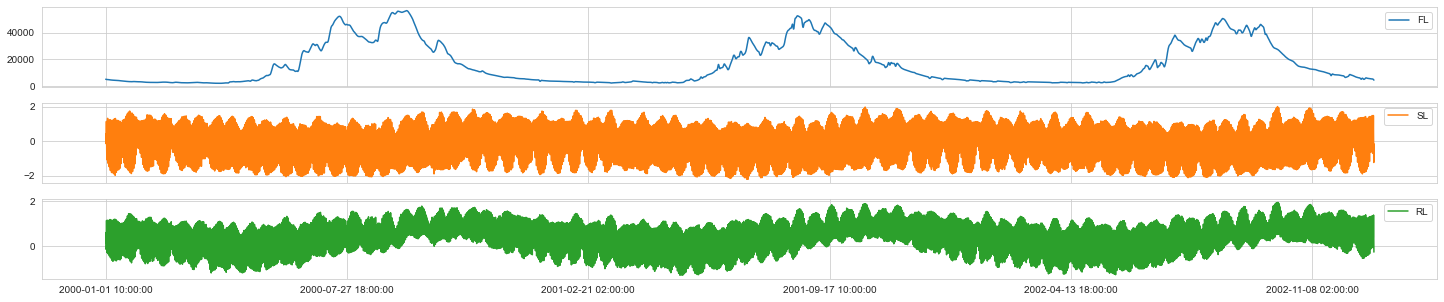

In [4]:
df.plot(subplots=True, figsize=(25,5))

We will standardize data 

In [5]:
dataset_=df.values
data_mean = dataset_[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset_[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset_-data_mean)/data_std
display(pd.DataFrame(dataset, columns = df.columns, index= df.index).head())

,FL,SL,RL
2000-01-01 10:00:00,-0.713133,-0.055065,-1.042132
2000-01-01 11:00:00,-0.713960,0.268276,-0.957009
2000-01-01 12:00:00,-0.714765,0.379773,-0.667592
2000-01-01 13:00:00,-0.715549,0.468971,-0.224955
2000-01-01 14:00:00,-0.716313,0.379773,0.064461


In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [7]:
past_history = 240
future_target = 24
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, PRED_INDEX], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, PRED_INDEX],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [8]:
print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target river flow to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(17760, 240, 3)
(17760, 24)
Single window of past history : (240, 3)
Target river flow to predict : (24,)


In [9]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [20]:
def create_time_steps(length):
    return list(range(-length, 0))

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    # only plot values less than 1 
    ax = plt.gca()
    ax.set_ylim([-.1, 1.1])
    plt.legend()

    plt.show()

    
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), '--bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), '--ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

(240, 3) (24,)


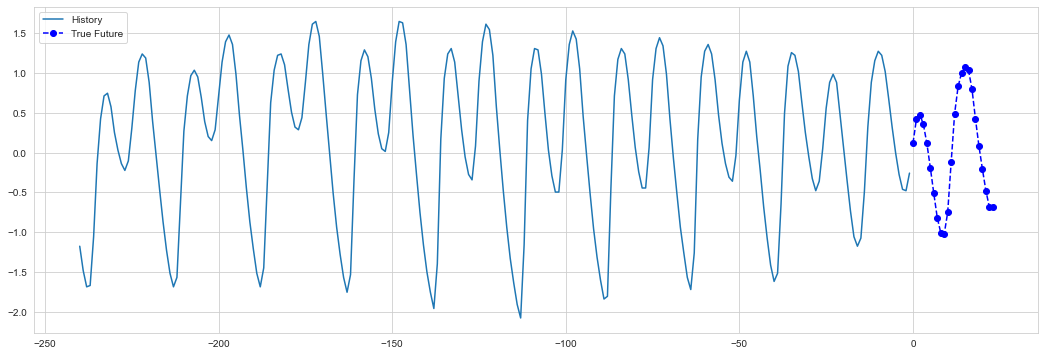

(240, 3) (24,)


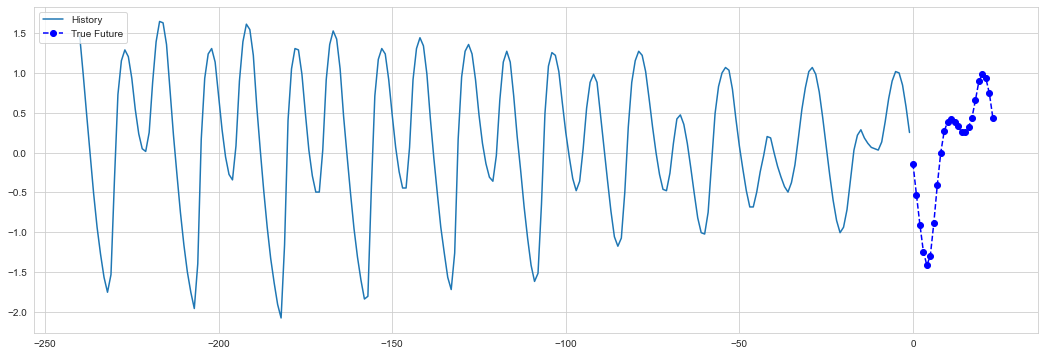

(240, 3) (24,)


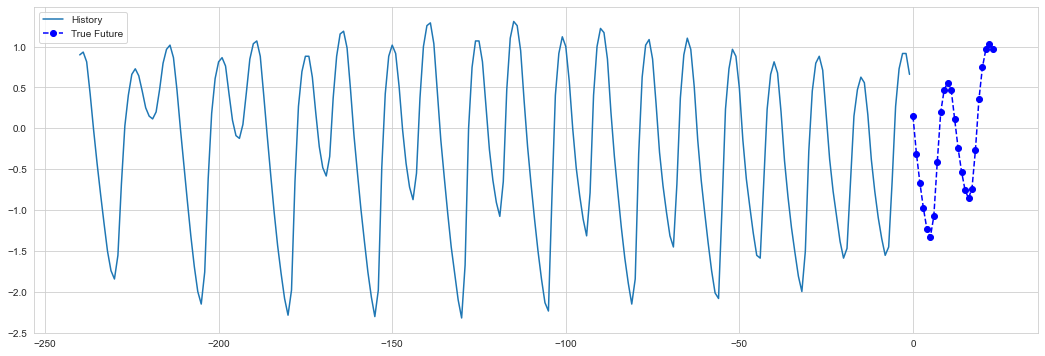

(240, 3) (24,)


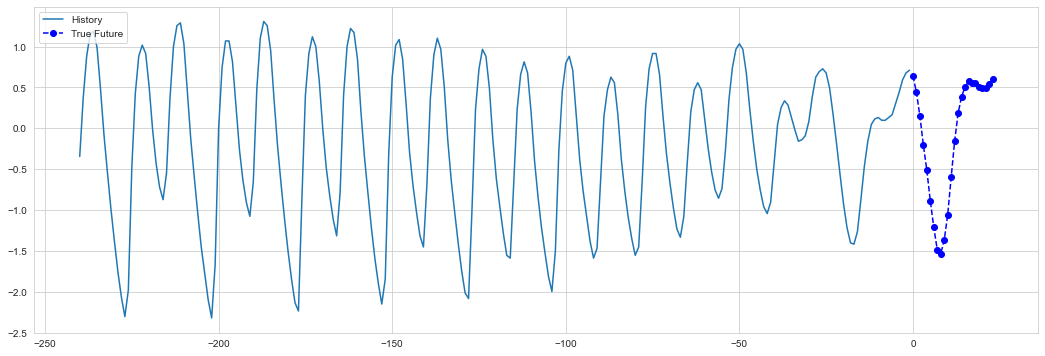

(240, 3) (24,)


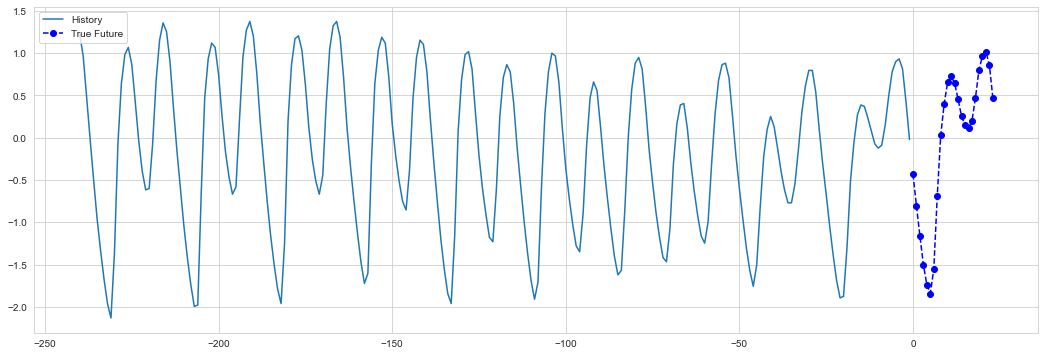

(240, 3) (24,)


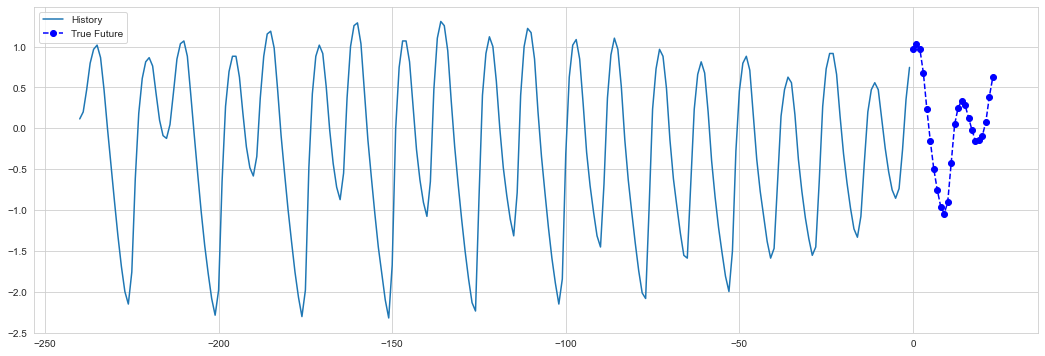

(240, 3) (24,)


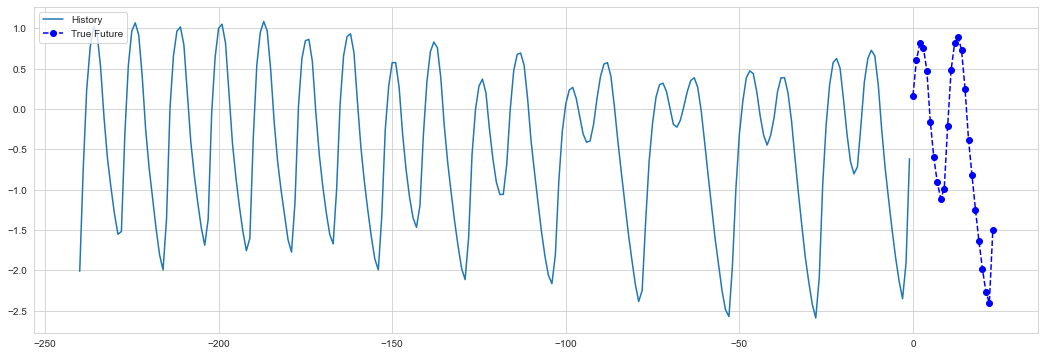

(240, 3) (24,)


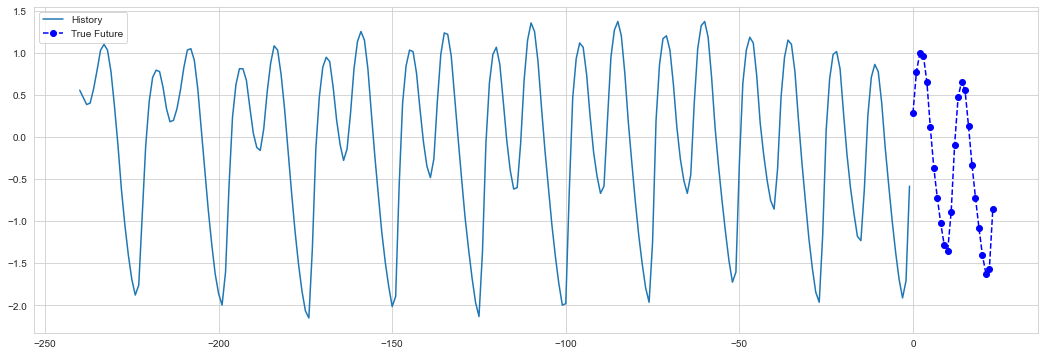

(240, 3) (24,)


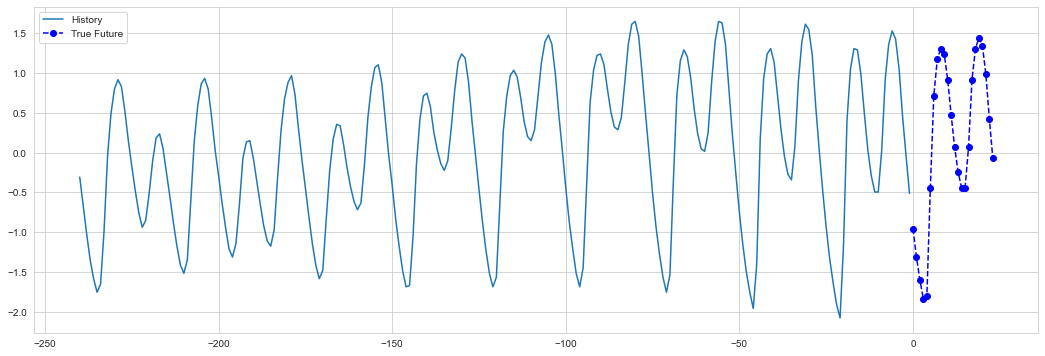

(240, 3) (24,)


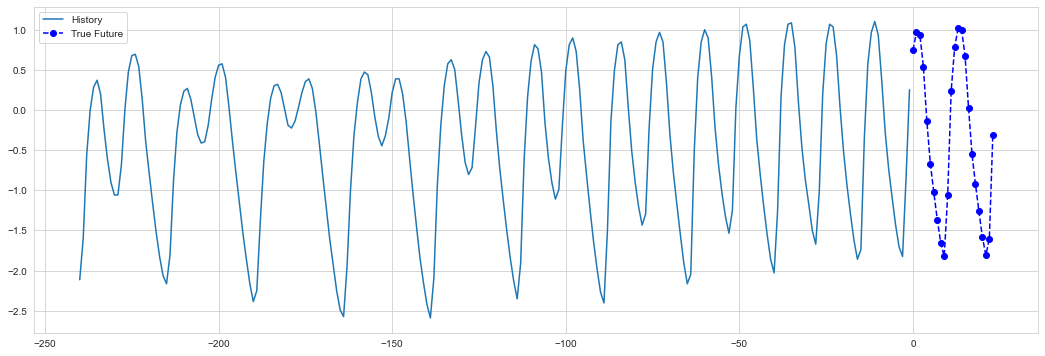

(240, 3) (24,)


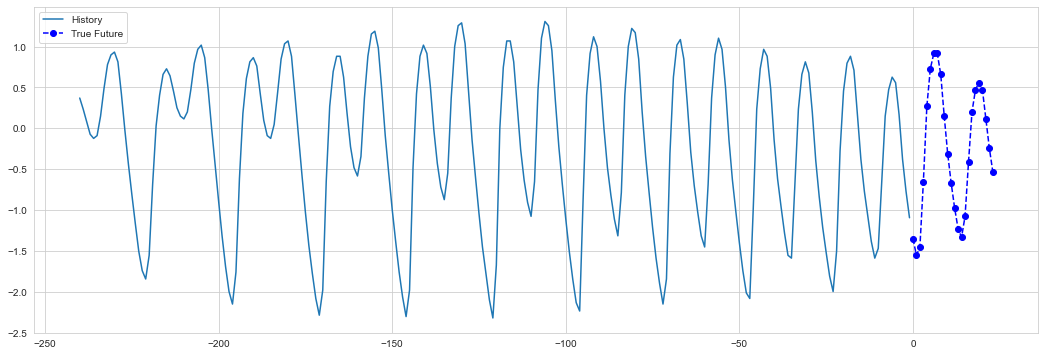

(240, 3) (24,)


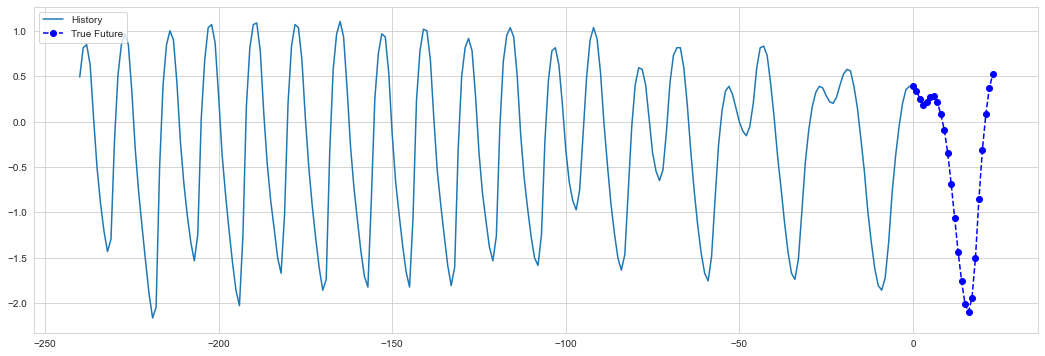

(240, 3) (24,)


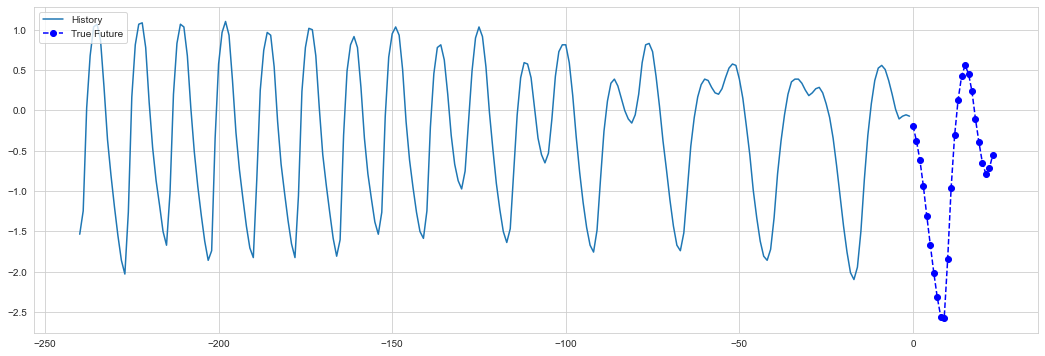

(240, 3) (24,)


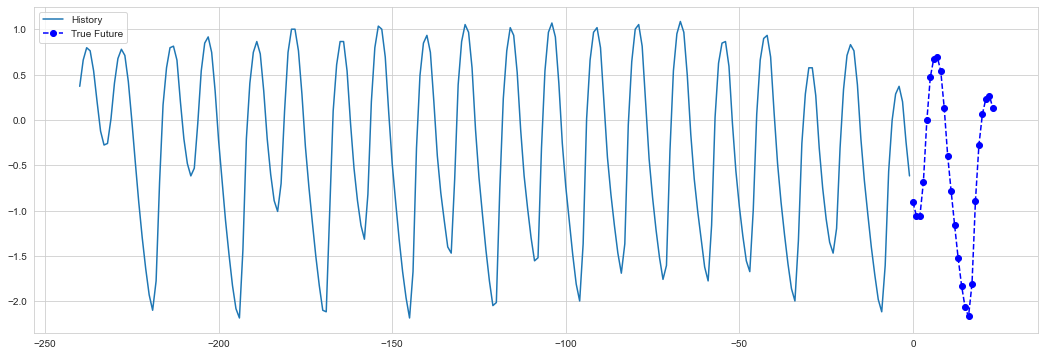

(240, 3) (24,)


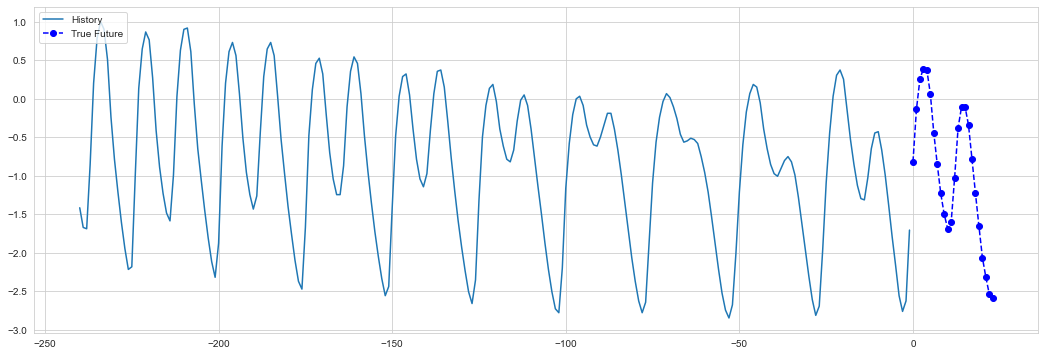

(240, 3) (24,)


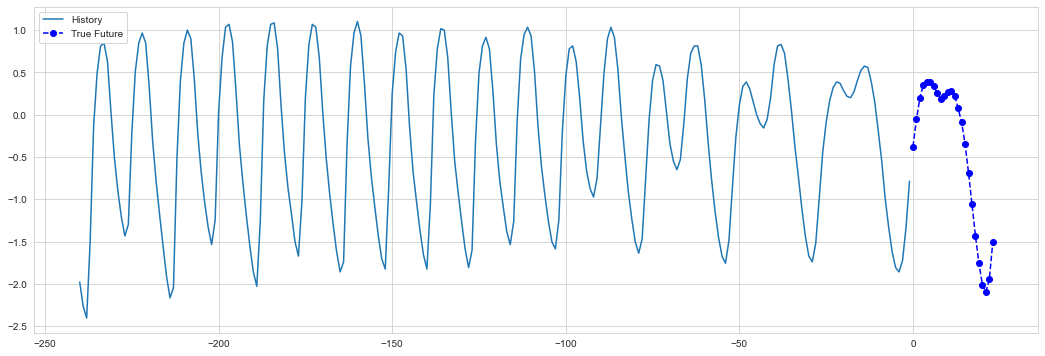

(240, 3) (24,)


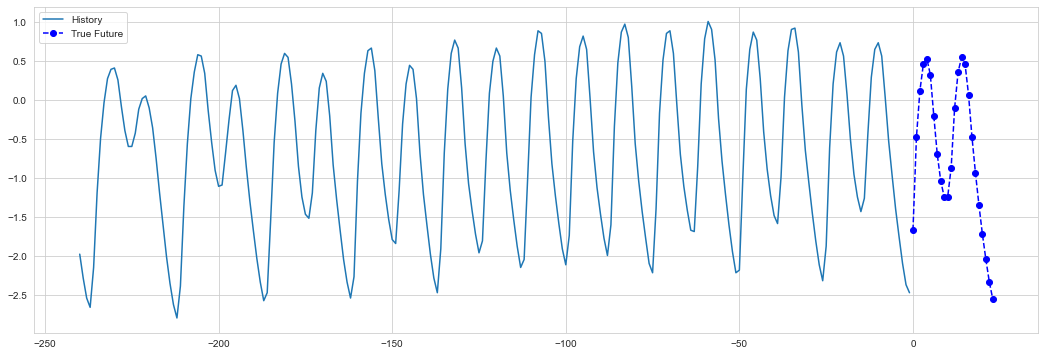

(240, 3) (24,)


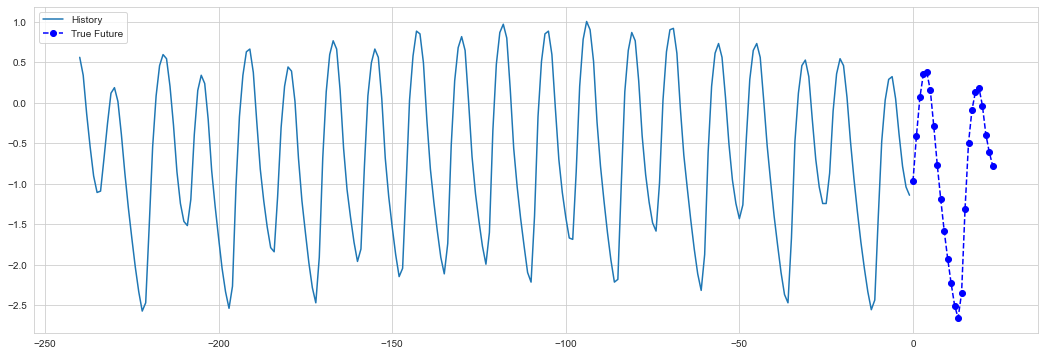

(240, 3) (24,)


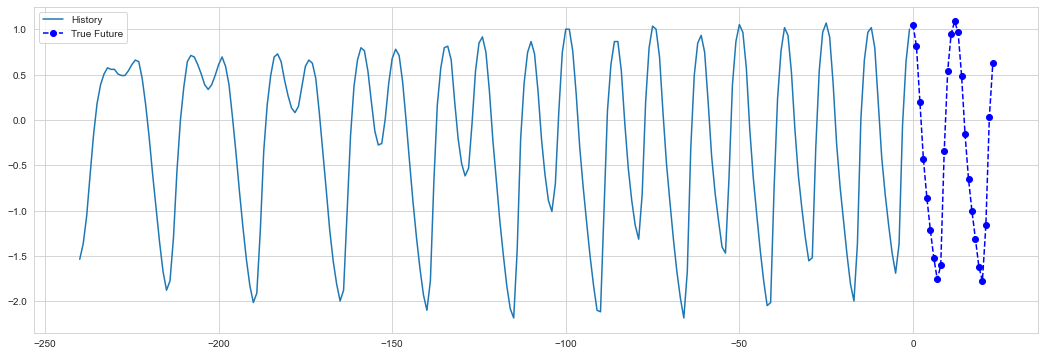

(240, 3) (24,)


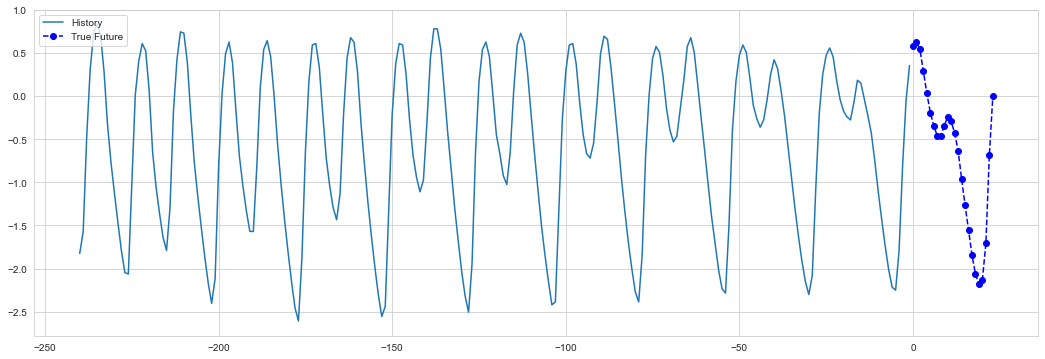

(240, 3) (24,)


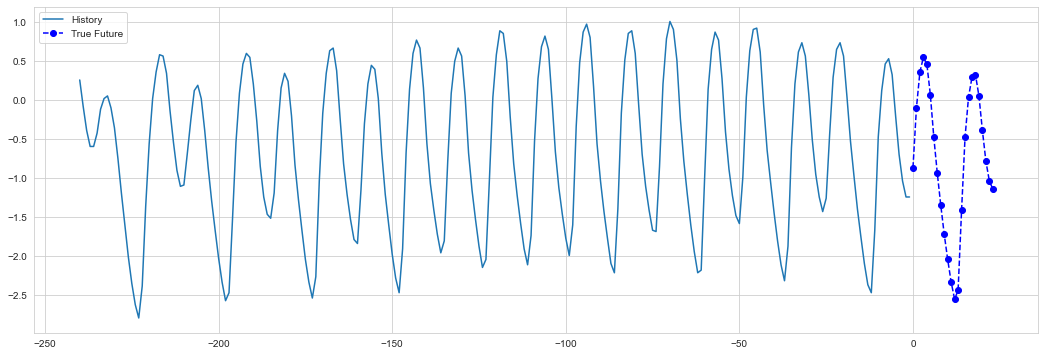

(240, 3) (24,)


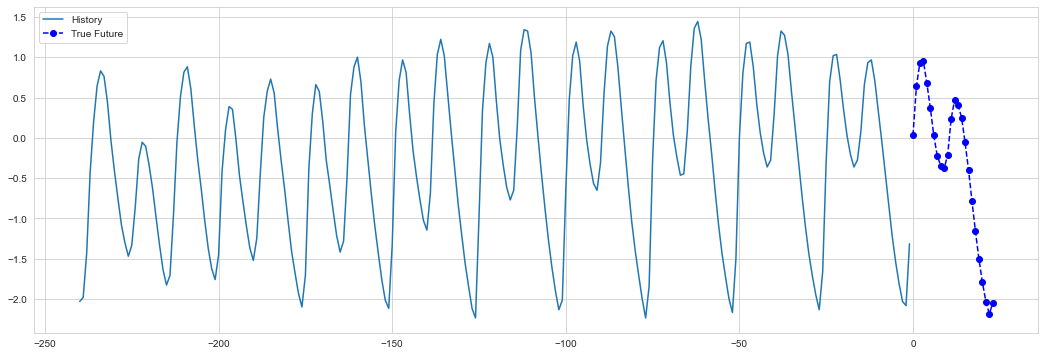

(240, 3) (24,)


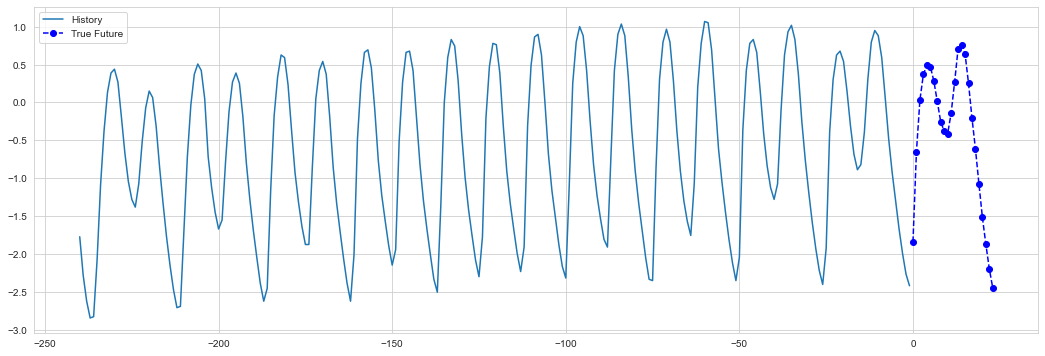

(240, 3) (24,)


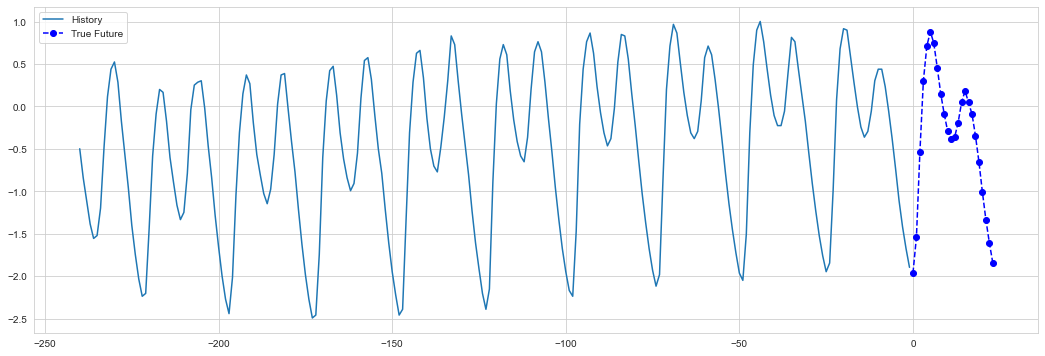

(240, 3) (24,)


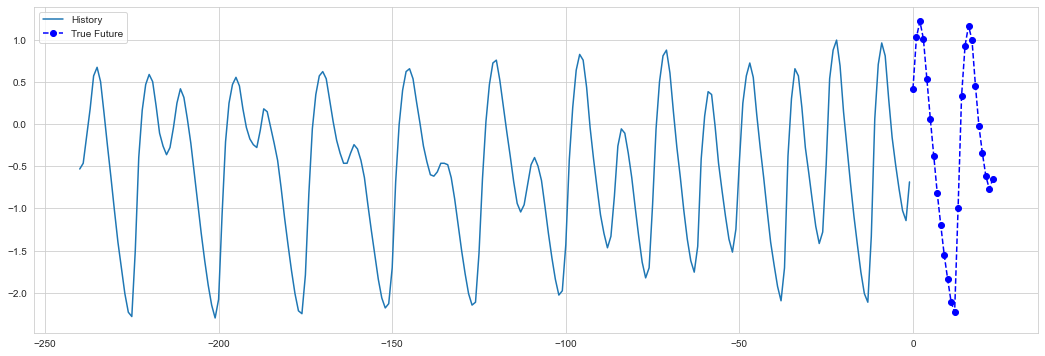

In [15]:
for x, y in train_data_multi.take(25):
    print(x[0].shape, y[0].shape, )
    multi_step_plot(x[0][:, PRED_INDEX], y[0], np.array([0]))
    


Let us use two LSTM layers. Finally, since 24 predictions are made, the dense layer outputs 24 predictions.

In [12]:
x_train_multi.shape[-2:]

(240, 3)

In [13]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 240, 32)           4608      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
Total params: 8,152
Trainable params: 8,152
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/4
200/200 [==============================] - 37s 178ms/step - loss: 0.7000 - val_loss: 0.6108
Epoch 2/4
200/200 [==============================] - 40s 200ms/step - loss: 78113601004503040.0000 - val_loss: 303963391112773632.0000
Epoch 3/4
200/200 [==============================] - 46s 232ms/step - loss: 9915715834347520.0000 - val_loss: 93715128320.0000
Epoch 4/4
200/200 [==============================] - 44s 219ms/step - loss: 265211232.0000 - val_loss: 0.3303


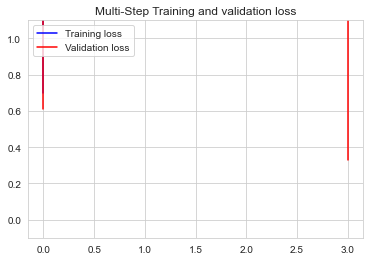

In [21]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
multi_step_model.save("model.keras")
# also save mean and standard diviation used in the model. 
with open("model.param","wb") as fp:
    pickle.dump([data_mean, data_std], fp)


#multi_step_model=tf.keras.models.load_model('model_good.keras')
#with open("model_good.param","rb") as fp:
#    data_mean, data_std = pickle.load(fp)
#    print(f"Mean : {data_mean} and std : {data_std}")

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 349ms/step


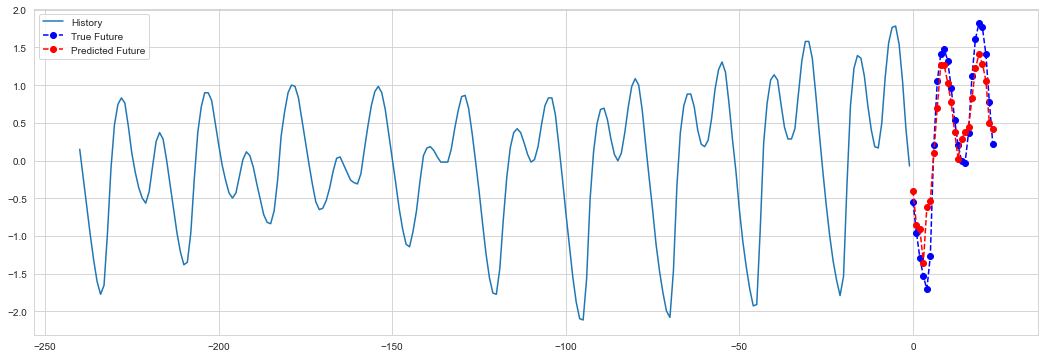

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 28ms/step


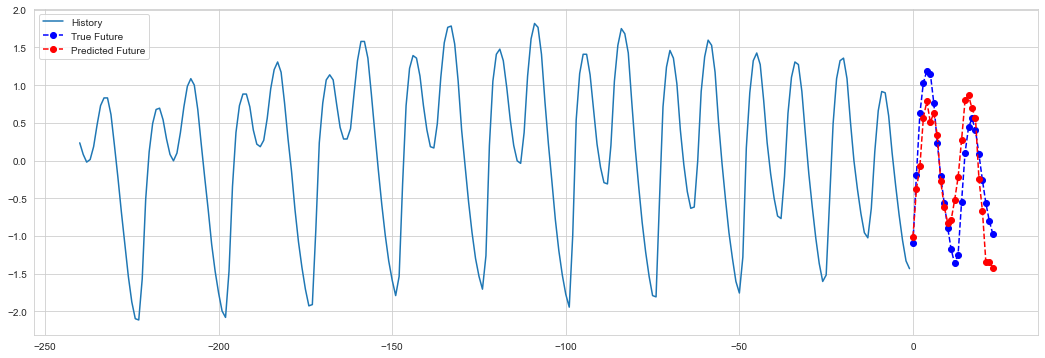

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 25ms/step


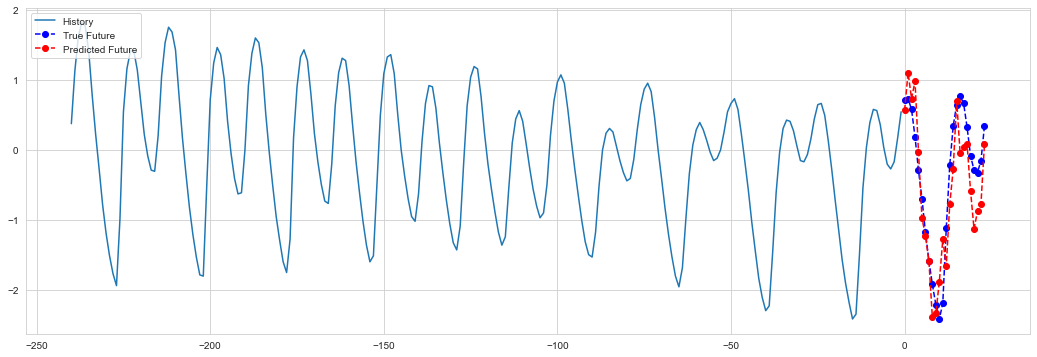

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 30ms/step


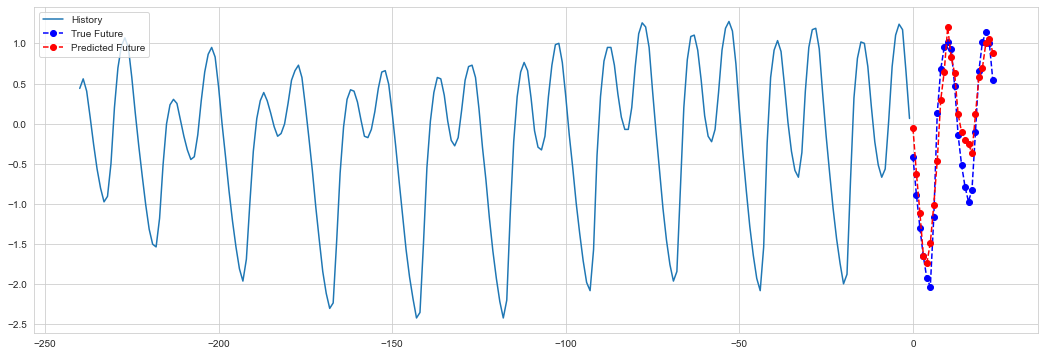

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 29ms/step


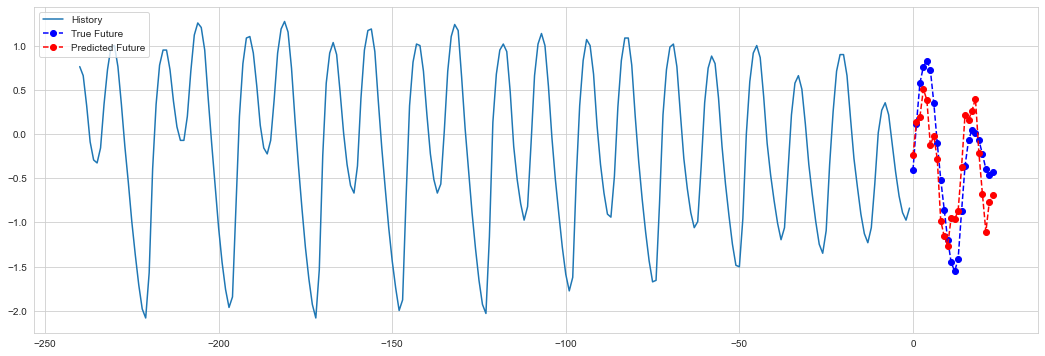

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 30ms/step


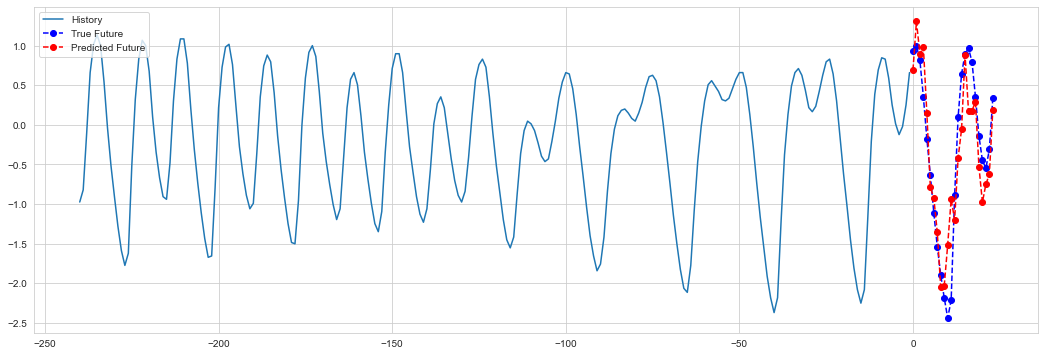

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 29ms/step


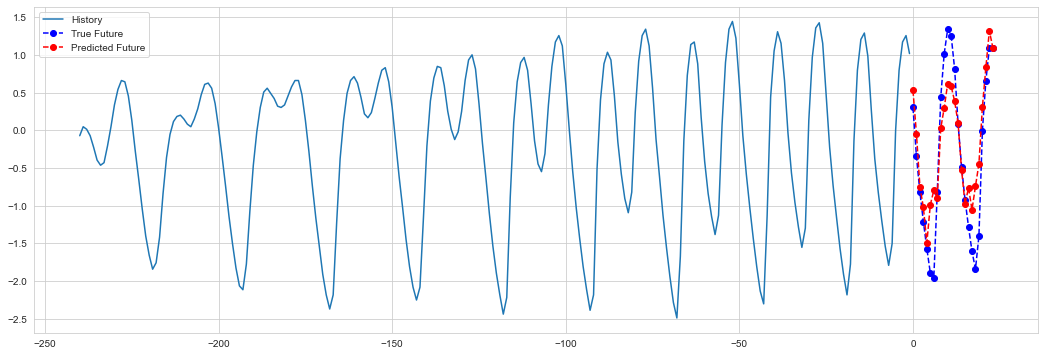

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 28ms/step


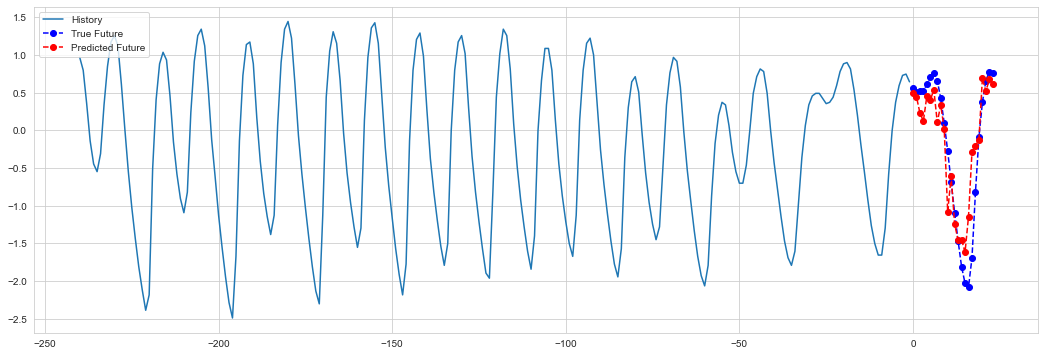

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 31ms/step


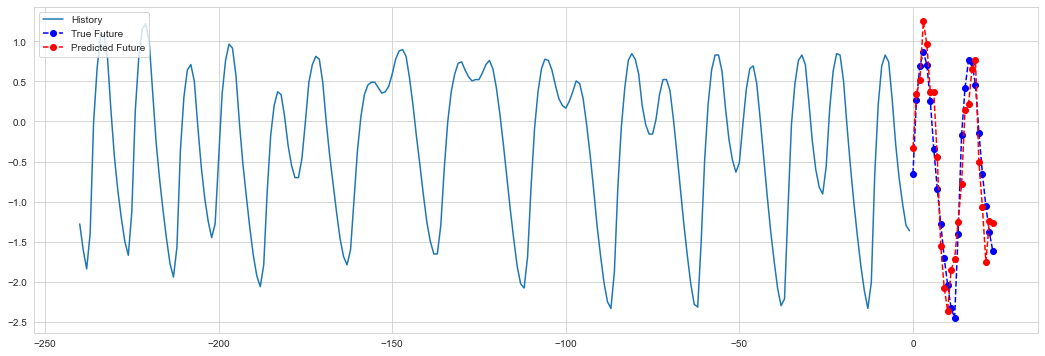

(128, 240, 3) (1, 240, 3)
1/1 [==============================] - 0s 29ms/step


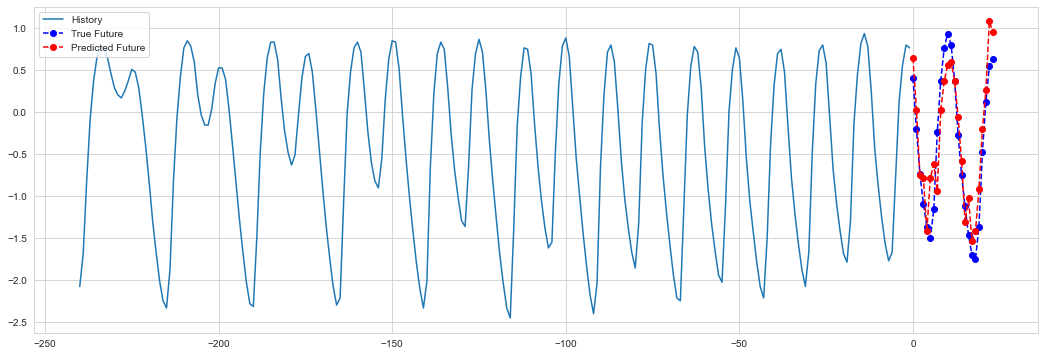

In [22]:
for x, y in val_data_multi.take(10):
    print(x.shape, np.array([x[0]]).shape)
    multi_step_plot(x[0][:,2], y[0], multi_step_model.predict(np.array([x[0]]))[0])

In [ ]:
#del multi_step_model, val_data_multi, train_data_multi
#_ = gc.collect()

In [ ]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))